This notebook is supplementary to the AM205 "Introduction to multithreading" workshop. It covers the basics of how to use ```NumPy``` and ```JAX```.

Notebook reference: https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

```JAX``` can be think of as an upgraded ```NumPy``` with automatic differentiation which runs on CPU, GPU and TPU. In the workshop we only covered multithreading on CPU and focused on one parallelization paradigm only (shared memory). If you are interested in making your Python code faster while doing machine learning related projects, then ```JAX``` may be a suitable candidate.

In the spirit of time, the notebook will not be able to go any deeper into the library or demonstrate all useful functions. If you are interested, you can read more about ```JAX``` starting from these (much better) references:

- Tutorial: JAX 101 https://jax.readthedocs.io/en/latest/jax-101/index.html
- You don't know JAX: https://colinraffel.com/blog/you-don-t-know-jax.html
- Introduction to JAX: https://www.youtube.com/watch?v=0mVmRHMaOJ4


## Load modules

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad,jit,pmap,vmap
from jax import random
import matplotlib.pyplot as plt

## What do we mean by vectorization?

## Matrix multiplication

According to the documentation, there are some differences in generating random numbers between the two libraries. For more details, see [Common Gotchas in JAX](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers).


In [2]:
# Ex.1 JAX random+dot
jseed=random.PRNGKey(0)
size=1000
mat_a=random.normal(jseed,(size,size),dtype=jnp.float32)
# Add block_until_ready() because JAX uses asynchronous execution by default
# You can use GPU/TPU by changing the runtime type in
# "Runtime > Change runtime type > Hardware accelerator"
%timeit jnp.dot(mat_a,mat_a.T).block_until_ready() # runs on the GPU

The slowest run took 1146.29 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.88 ms per loop


In [3]:
# Ex.2 NumPy random+dot
nseed=np.random.seed(0)
size=1000
nmat= np.random.normal(size=(size, size)).astype(np.float32)
%timeit np.dot(nmat,nmat.T)

100 loops, best of 5: 19 ms per loop


In [4]:
# Ex.3 NumPy random+JAX dot
%timeit jnp.dot(nmat,nmat.T).block_until_ready()

100 loops, best of 5: 5.09 ms per loop


## Four main functions for faster performance
- ```jit()```, for speeding up your code

- ```grad()```, for taking derivatives

- ```pmap()```, for running functions in parallel on multiple devices

- ```vmap()```, for automatic vectorization or batching


### ```jit()``` for speeding up your code

### ```grad()``` for taking derivatives

...whenever we want to speed up autograd and compute derivatives (_e.g._ activation function in training of some ML problems)

In [5]:
# A simple example of derivatives
# e.g. f(x)=x^4+3x^2+x*exp(x)+log(x)
def f(x):
    return x**4+3*x**2+x*jnp.exp(x)+jnp.log(x)

df1=grad(f)
df1

<function __main__.f>

In [6]:
# You can get the value of the 1st derivative by putting in x values
df1(1.0)

DeviceArray(16.436563, dtype=float32)

In [7]:
# You can just get the value by using float()
float(df1(1.0))

16.43656349182129

In [9]:
# However, integer numbers do not work
# For integers, you have to make them into floats
# Or else you will get a TypeError
df1(1)

TypeError: ignored

In [10]:
# We can get higher order derivatives
df2=grad(df1) # df2=grad(grad(f))
df3=grad(df2)

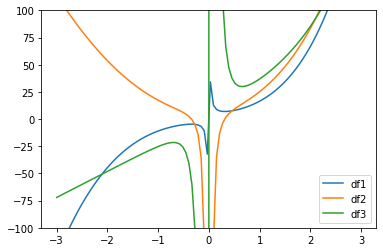

In [12]:
# Plot the four derivatives
x=np.linspace(-3,3,100)
plt.plot(x,[float(df1(xx)) for xx in x],label='df1')
plt.plot(x,[float(df2(xx)) for xx in x],label='df2')
plt.plot(x,[float(df3(xx)) for xx in x],label='df3')
plt.legend(loc='best')
plt.ylim(-100,100)
plt.show()

### ```pmap()``` and ```vmap()```
Please check the following references for more information:
- ```pmap()```: https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html
- ```vmap()```: https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html